In [10]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from PIL import Image
from utils import tile_raster_images
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
mnist = input_data.read_data_sets("../Lab1/MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images,\
    mnist.test.labels

Extracting ../Lab1/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../Lab1/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../Lab1/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../Lab1/MNIST_data/t10k-labels-idx1-ubyte.gz


# Utilities

In [12]:
def weights(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias(shape):
    initial = tf.zeros(shape, dtype=tf.float32)
    return tf.Variable(initial)

def sample_prob(probs):
    """Uzorkovanje vektora x prema vektoru vjerojatnosti p(x=1) = probs"""
    return tf.nn.relu(
        tf.sign(probs - tf.random_uniform(tf.shape(probs))))


def draw_weights(W, shape, N, interpolation="bilinear"):
    """Vizualizacija težina
    
    W -- vektori težina
    shape -- tuple dimenzije za 2D prikaz težina - obično dimenzije ulazne slike, npr. (28,28)
    N -- broj vektora težina
    """
    image = Image.fromarray( tile_raster_images(
        X=W.T,
        img_shape=shape,
        tile_shape=(int(math.ceil(N/20)), 20),
        tile_spacing=(1, 1)))
    plt.figure(figsize=(10, 14))
    plt.imshow(image, interpolation=interpolation)
    
def draw_reconstructions(ins, outs, states, shape_in, shape_state, Nh):
    """Vizualizacija ulaza i pripadajućih rekonstrkcija i stanja skrivenog sloja
    ins -- ualzni vektori
    outs -- rekonstruirani vektori
    states -- vektori stanja skrivenog sloja
    shape_in -- dimezije ulaznih slika npr. (28,28)
    shape_state -- dimezije za 2D prikaz stanja (npr. za 100 stanja (10,10)
    """
    plt.figure(figsize=(8, 12*4))
    for i in range(20):

        plt.subplot(20, 4, 4*i + 1)
        plt.imshow(ins[i].reshape(shape_in), vmin=0, vmax=1, interpolation="nearest")
        plt.title("Test input")
        plt.subplot(20, 4, 4*i + 2)
        plt.imshow(outs[i][0:784].reshape(shape_in), vmin=0, vmax=1, interpolation="nearest")
        plt.title("Reconstruction")
        plt.subplot(20, 4, 4*i + 3)
        plt.imshow(states[i][0:Nh].reshape(shape_state), vmin=0, vmax=1, interpolation="nearest")
        plt.title("States")
    plt.tight_layout()

# Zad 1

0 0.257246
5500 0.0321961
11000 0.0299504
16500 0.0288063
22000 0.0276258
27500 0.0295929
33000 0.029416
38500 0.0291402
44000 0.0290869
49500 0.0284203


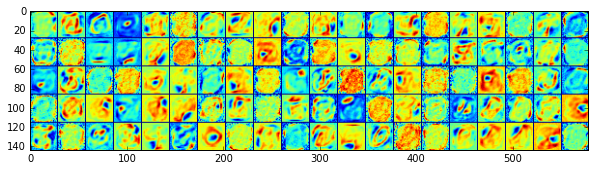

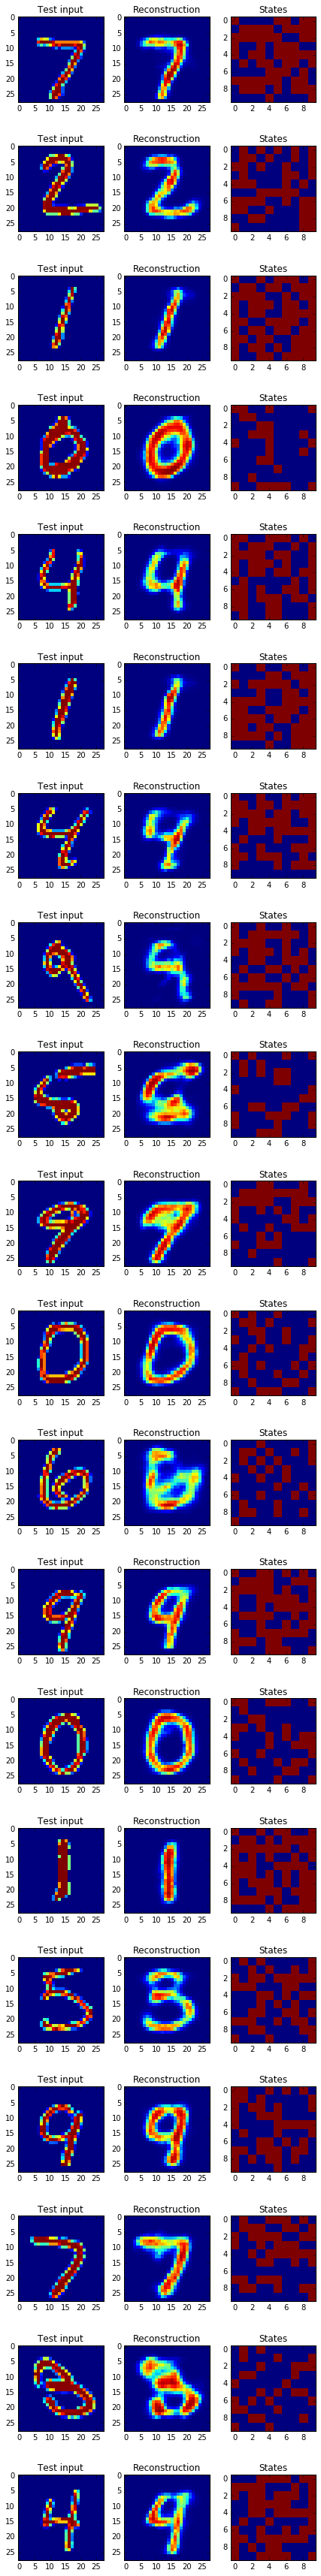

In [21]:
Nv = 784
v_shape = (28,28)
Nh = 100
h1_shape = (10,10)

gibbs_sampling_steps = 1
alpha = 0.1 # koeficijent učenja 

g1 = tf.Graph()
with g1.as_default():
    X1 = tf.placeholder("float", [None, 784])
    w1 = weights([Nv, Nh])
    vb1 = bias([Nv])
    hb1 = bias([Nh])
    
    h0_prob = tf.sigmoid(tf.matmul(X1,w1)+ hb1)  #minibatch x hidden
    h0 = sample_prob(h0_prob)
    h1 = h0

    for step in range(gibbs_sampling_steps):
        v1_prob = tf.sigmoid(tf.matmul(h1,tf.transpose(w1))+ vb1) 
        v1 = sample_prob(v1_prob)
        h1_prob = tf.sigmoid(tf.matmul(v1,w1)+ hb1)
        h1 = sample_prob(h1_prob)
    
    # pozitivna faza
    w1_positive_grad = tf.matmul(tf.transpose(X1),h1)
    
    # negativna faza
    w1_negative_grad = tf.matmul(tf.transpose(v1),h1)

    dw1 = (w1_positive_grad - w1_negative_grad) / tf.to_float(tf.shape(X1)[0])

    # operacije za osvježavanje parametara mreže - one pokreću učenje RBM-a
    update_w1 = tf.assign_add(w1, alpha * dw1)
    update_vb1 = tf.assign_add(vb1, alpha * tf.reduce_mean(X1 - v1_prob, 0))
    update_hb1 = tf.assign_add(hb1, alpha * tf.reduce_mean(h0 - h1, 0)) 

    out1 = (update_w1, update_vb1, update_hb1)
    
    # rekonstrukcija ualznog vektora - koristimo vjerojatnost p(v=1)
    v1_prob = tf.sigmoid(tf.matmul(h1,tf.transpose(w1))+ vb1)
    
    err1 = X1 - v1_prob
    err_sum1 = tf.reduce_mean(err1 * err1)
    
    initialize1 = tf.initialize_all_variables()

batch_size = 100
epochs = 100
n_samples = mnist.train.num_examples

total_batch = int(n_samples / batch_size) * epochs

with tf.Session(graph=g1) as sess:
    sess.run(initialize1)
    for i in range(total_batch):
        batch, label = mnist.train.next_batch(batch_size)
        err, _ = sess.run([err_sum1, out1], feed_dict={X1: batch})
        
        if i%(int(total_batch/10)) == 0:
            print i, err
    
    w1s = w1.eval()
    vb1s = vb1.eval()
    hb1s = hb1.eval()
    vr, h1s = sess.run([v1_prob, h1], feed_dict={X1: teX[0:20,:]})

# vizualizacija težina
draw_weights(w1s, v_shape, Nh) 

# vizualizacija rekonstrukcije i stanja
draw_reconstructions(teX, vr, h1s, v_shape, h1_shape, Nh)

# Zad 2

0 0.102879
5500 0.0524628
11000 0.0431617
16500 0.0454103
22000 0.0422641
27500 0.0439444
33000 0.0426025
38500 0.0411379
44000 0.0434948
49500 0.042518


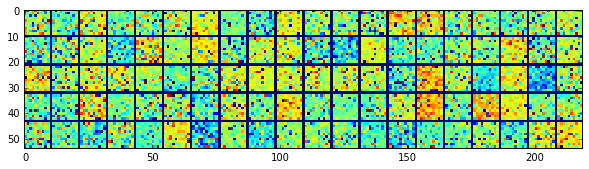

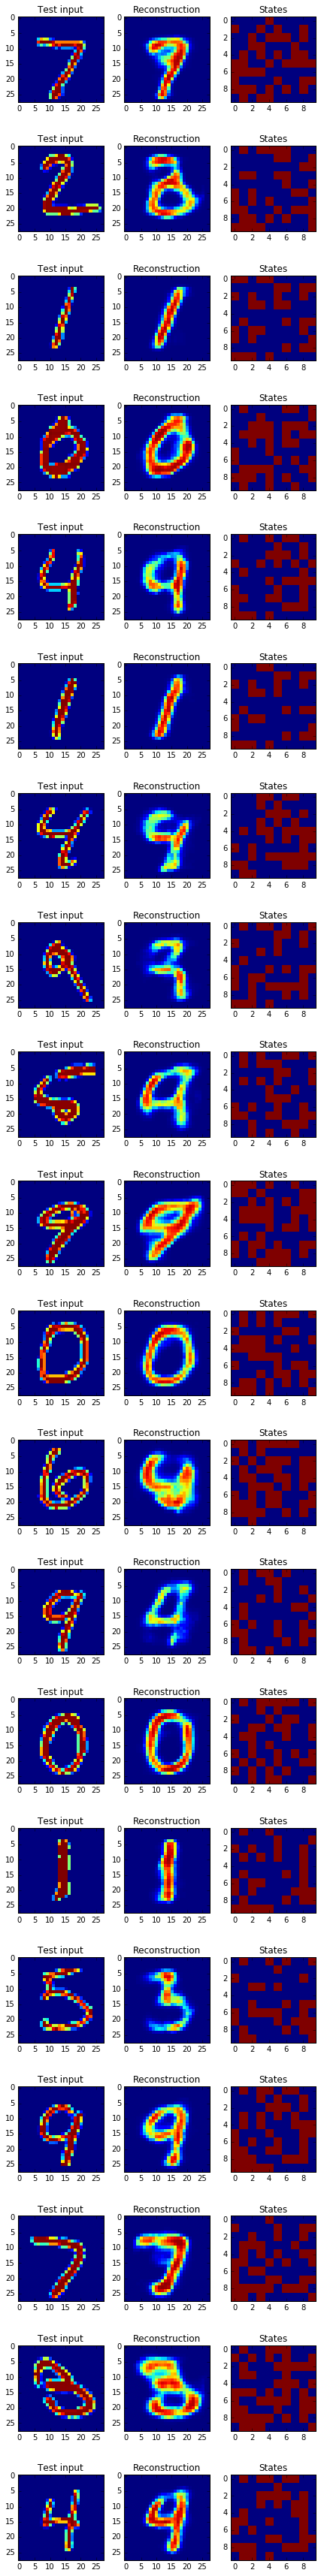

In [55]:
Nh2 = 100
h2_shape = (10,10) 
# Nh2 = 784
# h2_shape = (28,28)

gibbs_sampling_steps = 2
alpha = 0.05

g2 = tf.Graph()
with g2.as_default():
    X2 = tf.placeholder("float", [None, Nv])
    w1a = tf.Variable(w1s)
    vb1a = tf.Variable(vb1s)
    hb1a = tf.Variable(hb1s)
    w2 = weights([Nh, Nh2])
    vb2 = bias([Nh])
    hb2 = bias([Nh2])

#     dodatni zad
#     w2 = tf.Variable(w1s.transpose())
#     hb2 = bias([Nh2])
    
    # vidljivi sloj drugog RBM-a
    v2_prob  = tf.sigmoid(tf.matmul(X2,w1a)+ hb1a)
    v2 = sample_prob(v2_prob)
    # skriveni sloj drugog RBM-a
    h2_prob = tf.sigmoid(tf.matmul(v2,w2)+ hb2)
    h2 = sample_prob(h2_prob)
    h3 = h2
    
    for step in range(gibbs_sampling_steps):
        v3_prob = tf.sigmoid(tf.matmul(h3,tf.transpose(w2))+ vb2)
        v3 = sample_prob(v3_prob)
        h3_prob = tf.sigmoid(tf.matmul(v3,w2)+ hb2)
        h3 = sample_prob(h3_prob)
    
    w2_positive_grad = tf.matmul(tf.transpose(v2),h2)
    w2_negative_grad = tf.matmul(tf.transpose(v3),h3)

    dw2 = (w2_positive_grad - w2_negative_grad) / tf.to_float(tf.shape(v2)[0])

    update_w2 = tf.assign_add(w2, alpha * dw2)
    update_vb2 = tf.assign_add(vb2, alpha * tf.reduce_mean(v2 - v3, 0))
    update_hb2 = tf.assign_add(hb2, alpha * tf.reduce_mean(h2 - h3, 0))

    out2 = (update_w2, update_vb2, update_hb2)

    # rekonsturkcija ulaza na temelju krovnog skrivenog stanja h3
    # ...
    # ...
    
    v3_prob_n = tf.sigmoid(tf.matmul(h3,tf.transpose(w2))+ vb2)
    v3_n = sample_prob(v3_prob_n)
    v4_prob = tf.sigmoid(tf.matmul(v3_n,tf.transpose(w1a))+ vb1a)
    
    err2 = X2 - v4_prob
    err_sum2 = tf.reduce_mean(err2 * err2)
    
    initialize2 = tf.initialize_all_variables()

batch_size = 100
epochs = 100
n_samples = mnist.train.num_examples

total_batch = int(n_samples / batch_size) * epochs

with tf.Session(graph=g2) as sess:
    sess.run(initialize2)

    for i in range(total_batch):
        batch, label = mnist.train.next_batch(batch_size)
        err, _ = sess.run([err_sum2, out2], feed_dict={X2: batch})
        
        if i%(int(total_batch/10)) == 0:
            print i, err
            
    w2s, vb2s, hb2s = sess.run([w2, vb2, hb2], feed_dict={X2: batch})
    vr2, h3s = sess.run([v4_prob, h3], feed_dict={X2: teX[0:20,:]})

# vizualizacija težina
draw_weights(w2s, h1_shape, Nh2, interpolation="nearest")

# vizualizacija rekonstrukcije i stanja
draw_reconstructions(teX, vr2, h3s, v_shape, h2_shape, Nh2)

# 3. zad

0 0.0359736
5500 0.0355604
11000 0.0346412
16500 0.0356901
22000 0.0350585
27500 0.0366825
33000 0.0356487
38500 0.0377205
44000 0.0379577
49500 0.0346821


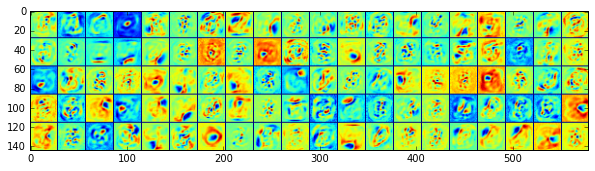

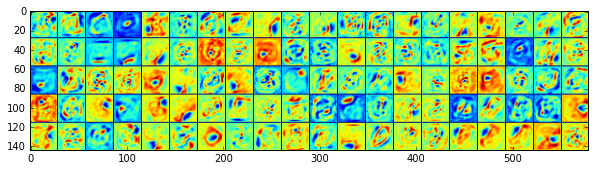

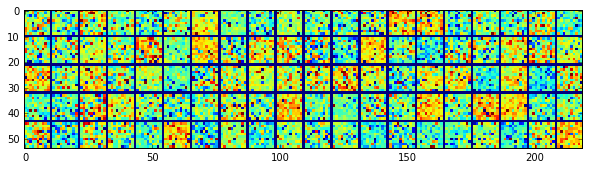

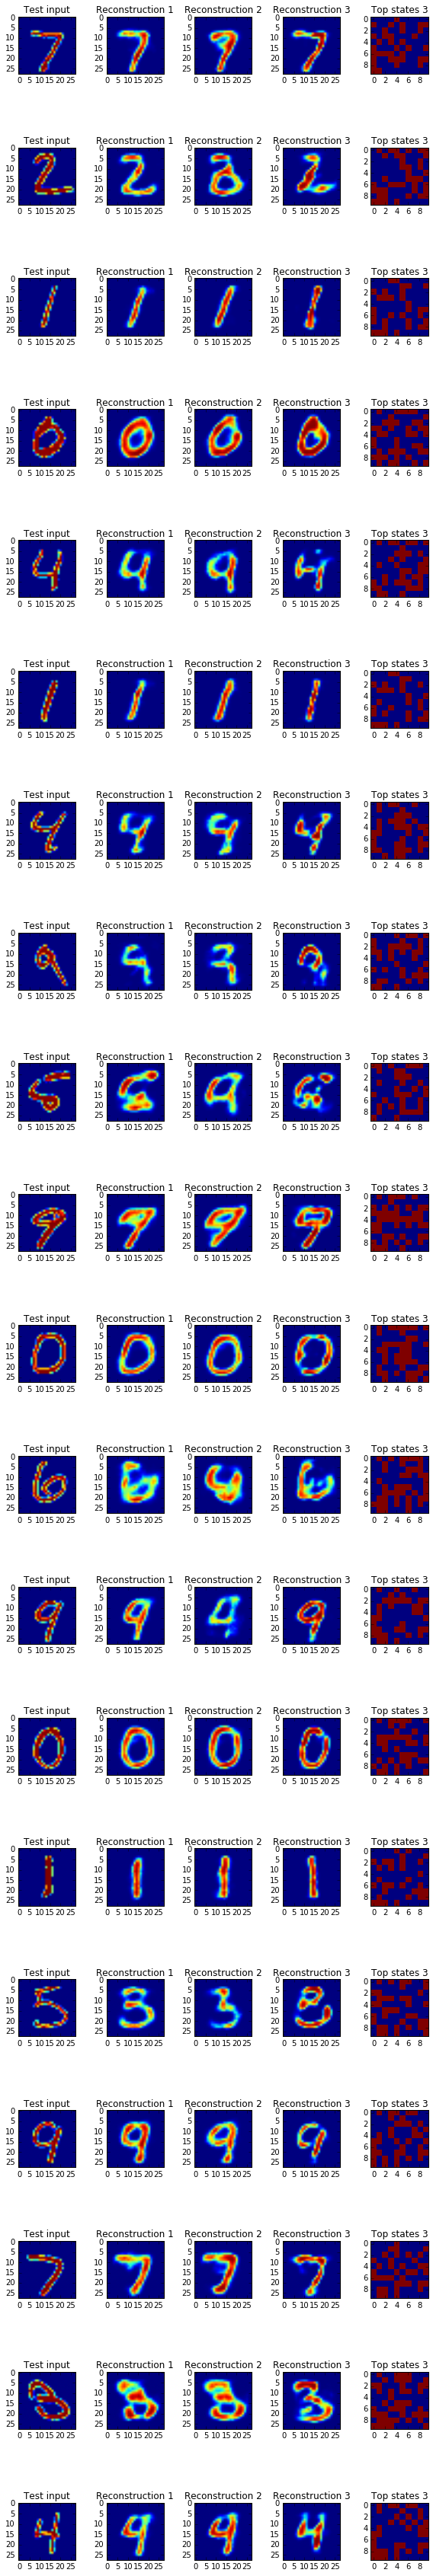

In [56]:
#
beta = 0.01

g3 = tf.Graph()
with g3.as_default():   
    X3 = tf.placeholder("float", [None, Nv])
    w1_up = tf.Variable(w1s)
    w1_down = tf.Variable(tf.transpose(w1s))
    w2a = tf.Variable(w2s)
    hb1_up = tf.Variable(hb1s)
    hb1_down = tf.Variable(vb2s)
    vb1_down = tf.Variable(vb1s)
    hb2a = tf.Variable(hb2s)
    
    # wake pass mejbi kriv
    h1_up_prob = tf.sigmoid(tf.matmul(X3,w1_up)+ hb1_up)
    h1_up = sample_prob(h1_up_prob)# s^{(n)} u pripremi
    v1_up_down_prob = tf.sigmoid(tf.matmul(h1_up, w1_down)+ vb1_down) #what the fuck
    v1_up_down = sample_prob(v1_up_down_prob)# s^{(n-1)\mathit{novo}} u pripremi  
    
    
    
    # top RBM Gibs passes
    h2_up_prob = tf.sigmoid(tf.matmul(h1_up,w2a)+ hb2a)
    h2_up = sample_prob(h2_up_prob)
    h4 = h2_up
    for step in range(gibbs_sampling_steps):
        h1_down_prob = tf.sigmoid(tf.matmul(h4,tf.transpose(w2a))+ hb1_down)
        h1_down = sample_prob(h1_down_prob)
        h4_prob = tf.sigmoid(tf.matmul(h1_down,w2a)+ hb2a)
        h4 = sample_prob(h4_prob)
       
    # sleep pass
    v1_down_prob = tf.sigmoid(tf.matmul(h1_down,w1_down) + vb1_down)
    v1_down = sample_prob(v1_down_prob)# s^{(n-1)} u pripremi
    h1_down_up_prob = tf.sigmoid(tf.matmul(v1_down, w1_up) + hb1_up)
    h1_down_up = sample_prob(h1_down_up_prob)# s^{(n)\mathit{novo}} u pripremi
    
    
    # generative weights update during wake pass
    update_w1_down = tf.assign_add(w1_down, beta * tf.matmul(tf.transpose(h1_up), X3 - v1_up_down_prob) / tf.to_float(tf.shape(X3)[0]))
    update_vb1_down = tf.assign_add(vb1_down, beta * tf.reduce_mean(X3 - v1_up_down_prob, 0))
    

    # top RBM update
    w2_positive_grad = tf.matmul(tf.transpose(h1_up),h2_up)
    w2_negative_grad = tf.matmul(tf.transpose(h1_down),h4)
    dw3 = (w2_positive_grad - w2_negative_grad) / tf.to_float(tf.shape(h1_up)[0])
    update_w2 = tf.assign_add(w2a, beta * dw3)
    update_hb1_down = tf.assign_add(hb1_down, beta * tf.reduce_mean(h1_up - h1_down, 0))
    update_hb2 = tf.assign_add(hb2a, beta * tf.reduce_mean(h2_up - h4, 0))
    
    # recognition weights update during sleep pass
    update_w1_up = tf.assign_add(w1_up, beta * tf.matmul(tf.transpose(v1_down_prob), h1_down - h1_down_up) / tf.to_float(tf.shape(X3)[0]))
    update_hb1_up = tf.assign_add(hb1_up, beta * tf.reduce_mean(h1_down - h1_down_up, 0))###########^ #####
    
    out3 = (update_w1_down, update_vb1_down, update_w2, update_hb1_down, update_hb2, update_w1_up, update_hb1_up)
    
    err3 = X3 - v1_down_prob
    err_sum3 = tf.reduce_mean(err3 * err3)
    
    initialize3 = tf.initialize_all_variables()

batch_size = 100
epochs = 100
n_samples = mnist.train.num_examples

total_batch = int(n_samples / batch_size) * epochs

with tf.Session(graph=g3) as sess:
    sess.run(initialize3)
    for i in range(total_batch):
        batch, label = mnist.train.next_batch(batch_size)
        err, _ = sess.run([err_sum3, out3], feed_dict={X3: batch})
        
        if i%(int(total_batch/10)) == 0:
            print i, err
    
    w2ss, w1_ups, w1_downs, hb2ss, hb1_ups, hb1_downs, vb1_downs = sess.run(
        [w2a, w1_up, w1_down, hb2a, hb1_up, hb1_down, vb1_down], feed_dict={X3: batch})
    vr3, h4s, h4_probs = sess.run([v1_down_prob, h4, h4_prob], feed_dict={X3: teX[0:20,:]})

# vizualizacija težina
draw_weights(w1_ups, v_shape, Nh)
draw_weights(w1_downs.T, v_shape, Nh)
draw_weights(w2ss, h1_shape, Nh2, interpolation="nearest")

# vizualizacija rekonstrukcije i stanja
Npics = 5
plt.figure(figsize=(8, 12*4))
for i in range(20):

    plt.subplot(20, Npics, Npics*i + 1)
    plt.imshow(teX[i].reshape(v_shape), vmin=0, vmax=1)
    plt.title("Test input")
    plt.subplot(20, Npics, Npics*i + 2)
    plt.imshow(vr[i][0:784].reshape(v_shape), vmin=0, vmax=1)
    plt.title("Reconstruction 1")
    plt.subplot(20, Npics, Npics*i + 3)
    plt.imshow(vr2[i][0:784].reshape(v_shape), vmin=0, vmax=1)
    plt.title("Reconstruction 2")
    plt.subplot(20, Npics, Npics*i + 4)
    plt.imshow(vr3[i][0:784].reshape(v_shape), vmin=0, vmax=1)
    plt.title("Reconstruction 3")
    plt.subplot(20, Npics, Npics*i + 5)
    plt.imshow(h4s[i][0:Nh2].reshape(h2_shape), vmin=0, vmax=1, interpolation="nearest")
    plt.title("Top states 3")
plt.tight_layout()